In [126]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, accuracy_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [127]:
def printest(args, value):
    return print( "{} : \n {} \n".format(args, value) )

# Logistic Regression - data preparation and model training

Churn prediction is about identifying customers who are likely to cancel their contracts soon. If the company can do that, it can offer discounts on these services in an effort to keep the users. Here we use the dataset of churn prediction for a telecom company.

- A value of 0 indicates that the customer did not churn (they stayed with the service).
- A value of 1 indicates that the customer did churn (they left the service).

In [128]:
df = pd.read_csv('Data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Convert 'TotalCharges' to numeric, replace non-numeric with NaN
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')
# Fill NaN values with zero
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# lowering columns name and replace spaces by _
df.columns  = df.columns.str.lower().str.replace(' ', '_')


# boolean mask to select columns with object type (string)
obj_mask = df.dtypes == 'object' 
obj_columns = list(df.dtypes[obj_mask].index)

# lowering rows strings and replace spaces by _
for col in obj_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

# turn 'no' into 0 and 'yes' into 1
df.churn = (df.churn == 'yes').astype(int)

In [129]:
# split data in train, test, validation
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

# save target values
y_train = df_train['churn'].values
y_val = df_val['churn'].values

# take out the target values from the dataframe
del df_train['churn']
del df_val['churn']

In [130]:
# All categorical columns except 'customerid'
categorical_mask = df_train.dtypes == 'object'
categorical = list(df_train.dtypes[categorical_mask].index)
categorical.remove('customerid') 

# Manually add 'seniorcitizen' because it's an int boolean (0 or 1)
categorical.append('seniorcitizen')
printest('categorical', categorical)

# All numerical columns except 'seniorcitizen' because it's an int boolean
numerical_mask = df_train.dtypes != 'object'
numerical = list(df_train.dtypes[numerical_mask].index)
numerical.remove('seniorcitizen')
printest('numerical', numerical)

categorical : 
 ['gender', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'seniorcitizen'] 

numerical : 
 ['tenure', 'monthlycharges', 'totalcharges'] 



In [131]:
# transform dataframe to dict
train_dict = df_train[categorical + numerical].to_dict(orient='records')

# One-hot encoding
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)

# Model train for all relevant features
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [132]:
# validate the model
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)
printest('Prob Not churn| Prob Churn',y_pred)

Prob Not churn| Prob Churn : 
 [[0.76508893 0.23491107]
 [0.7311339  0.2688661 ]
 [0.6805482  0.3194518 ]
 ...
 [0.94274725 0.05725275]
 [0.38476961 0.61523039]
 [0.93872737 0.06127263]] 



In [133]:
# training the model for a subset of features
small_subset = ['contract', 'tenure', 'totalcharges']
train_dict_small = df_train[small_subset].to_dict(orient='records')
dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)

X_small_train = dv_small.transform(train_dict_small)

model_small = LogisticRegression(solver='liblinear', random_state=1)
model_small.fit(X_small_train, y_train)

val_dict_small = df_val[small_subset].to_dict(orient='records')
X_small_val = dv_small.transform(val_dict_small)

y_pred_small = model_small.predict_proba(X_small_val)
printest('Prob Not churn| Prob Churn',y_pred)

Prob Not churn| Prob Churn : 
 [[0.76508893 0.23491107]
 [0.7311339  0.2688661 ]
 [0.6805482  0.3194518 ]
 ...
 [0.94274725 0.05725275]
 [0.38476961 0.61523039]
 [0.93872737 0.06127263]] 



# Metrics

Evaluation metrics serve as a critical tool for quantifying the performance of a model. They function by assessing the model's predictions against the actual observed values. This comparison yields a measurement that indicates the model's predictive accuracy. Therefore, evaluation metrics provide an essential insight into the model's proficiency and its ability to generalize to unseen data.

# Classification accuracy

The accuracy of a binary classification model is determined by the proportion of predictions it correctly makes relative to the total number of predictions. In mathematical terms, this can be represented as:

$$\text{Accuracy} = \frac{\text{correct}}{\text{total}} = \frac{1491}{1860} = 80\%$$

This metric provides valuable insight into the model's performance. By tallying the instances where our model's predictions align with the actual results.

In [134]:
# calculate accuracy explicitly
y_pred = model.predict_proba(X_val)[:, 1]
# probability threshold
churn = y_pred >= 0.5
correct = (y_val == churn).sum()
total = len(y_val)
accuracy = correct/total
printest('Full Model Accuracy', accuracy)

Full Model Accuracy : 
 0.8016129032258065 



In [138]:
# calculate accuracy explicitly
y_pred_small = model_small.predict_proba(X_small_val)[:, 1]
# probability threshold
churn = y_pred_small >= 0.5
correct = (y_val == churn).sum()
total = len(y_val)
accuracy = correct/total
printest('Small Model Accuracy', accuracy)

Small Model Accuracy : 
 0.7672043010752688 



In order to determine the optimal threshold, we can iteratively calculate the accuracy for a range of potential threshold values. This process allows us to assess the performance of our model at various decision boundaries, thereby enabling us to select the threshold that yields the highest accuracy.

In [ ]:
thresholds = np.linspace(0, 1, 21)

accuracies = []

for t in thresholds:
    acc = accuracy_score(y_val, y_pred >= t)
    accuracies.append(acc)
    #print('%0.2f %0.3f' % (t, acc))

# Create a dictionary
data = {'threshold': thresholds, 'accuracy': accuracies}

# Create DataFrame
df_acc = pd.DataFrame(data)

# Print DataFrame
display(df_acc.set_index('threshold'))

,accuracy
threshold,
0.00,0.261290
0.05,0.501075
0.10,0.594624
0.15,0.640323
0.20,0.689785
0.25,0.729570
0.30,0.754839
0.35,0.767204
0.40,0.781720


As we see, using the threshold of 0.5 gives us the best accuracy. Typically, 0.5 is a good
threshold value to start with. To make it more visual, we can use Matplotlib to create a plot that shows how accuracy changes depending on the threshold

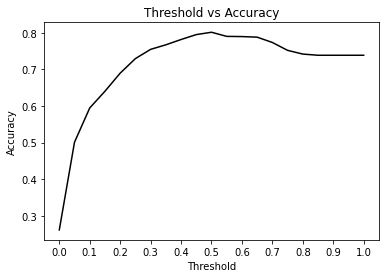

In [ ]:
plt.figure(figsize=(6, 4))

plt.plot(df_acc['threshold'].values, df_acc['accuracy'].values, color='black')

plt.title('Threshold vs Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

plt.xticks(np.linspace(0, 1, 11))

# plt.savefig('04_threshold_accuracy.svg')

plt.show()

## Dummy baseline

Establishing a baseline is an important step in evaluating the performance of our predictive models. For this purpose, we often use a dummy model — a simple construct which consistently predicts the same outcome, regardless of the input features. In our case, it consistently outputs 'False'. 

By comparing the performance of our complex models against this baseline, we gain a clear understanding of their incremental improvement in predictive accuracy. 

In [140]:
# dummy model that outputs only False
size_val = len(y_val)
baseline = np.repeat(False, size_val)


printest('Full Model Accuracy', accuracy)
printest('Small Model Accuracy', accuracy)
printest('Baseline accuracy', accuracy_score(baseline, y_val))

Full Model Accuracy : 
 0.7672043010752688 

Small Model Accuracy : 
 0.7672043010752688 

Baseline accuracy : 
 0.7387096774193549 



Observing the performance of our models, we notice that the smaller model surpasses the naive baseline by a marginal 2%, while the larger model achieves a slightly better improvement of 6%. According to accuracy metrics, our model only offers a marginal improvement over a rudimentary model that categorizes all customers as non-churning and makes no effort to retain them. 

This phenomenon often arises in scenarios where there is class imbalance, a condition wherein one class outnumbers the other. This imbalance is indeed apparent in our dataset, where 74% of customers didn't churn while only 26% did. For this we need another metric that validate the model.

# Confusion Matrix and Measures


**Confusion Matrix for multiple classes**

The accuracy is a global measure in that it does not explicitly consider the classes that contribute to the error. A more detailed understanding can be achieved by noting the agreement and disagreement for specific classes between the actual and predicted labels in the validation or test set. 

Consider a typical dataset for the validation points with multiple classes,
$$\mathbf{D} =
\left( \begin{array}{c|cccc|c}
~    &X_{0}&X_{1}&\cdots & X_{d}  & Y\\
\hline
\mathbf{x}_{1} &1& x_{11}& \cdots&x_{1d}&y_1 \\
\vdots&\vdots&\vdots&\ddots&\vdots&\vdots\\
\mathbf{x}_{n}&1&x_{n1}&\cdots&x_{nd}&y_n
\end{array} \right).$$

The target values, denoted as $\mathbf{Y} = (y_1, \cdots, y_i, \cdots, y_n)$, are not binary; instead, each $y_i \in \{c_1, \cdots, c_k\}$ represents one of $k$ class labels. Here, $\mathcal{D}= \{\mathbf{D}_1,\mathbf{D}_2, \cdots,\mathbf{D}_k\}$ denotes the division of validation data according to their true class labels $y$.

The $j^{th}$ split for the target values $y_i$ on the validation set is defined as:

$$\mathbf{D}_j = \{\mathbf{x}_i | y_i = c_j\}$$

with $n_i = |\mathbf{D}_i|$ as the count of the true class $c_i$ within the validation set.

Another division is conducted based on the predicted values from the validation set, forming $\mathcal{R} = \{\mathbf{R}_1, \mathbf{R}_2, \cdots, \mathbf{R}_k\}$. This denotes that the $j^{th}$ partition for the predicted target value $\hat{y}_i$ on the validation set is:

$$\mathbf{R}_j = \{\mathbf{x}_i | \hat{y}_i = c_j\}$$

and $m_i = |\mathbf{R}_i|$ represents the quantity of the predicted class $c_j$.

The divisions $\mathcal{R}$ and $\mathcal{D}$ yield a $k \times k$ matrix $\mathbf{N}$, better known as a confusion matrix. This matrix illustrates the intersections of each partition from the sets $\mathcal{R}$ and $\mathcal{D}$:

$$\mathbf{N}(i,j) = n_{ij} = |\mathbf{R}_i \cap \mathbf{D}_j |  = |\{\mathbf{x}_a \in \mathbf{D}| \hat{y}_a = c_j ~~\text{and} ~~ y_a = c_i \}|$$

For $1\leq i$, $j \leq k$, $n_{ij}$ represents the count of instances with a predicted class of $c_i$ and an actual label of $c_j$. These matrix values account for the total instances in each intersection. The matrix is presented as:

$$\mathbf{N} =
\left( \begin{array}{c|cccc}
~  y_{i} |~~\hat{y}_i  &c_{1}&c_{2}&\cdots & c_{k} \\
\hline
{c}_{1} &n_{11}& n_{12}& \cdots&n_{1k} \\
{c}_{2} &n_{21}& n_{22}& \cdots&n_{2k} \\
\vdots&\vdots&\vdots&\ddots&\vdots&\\
c_{k}&n_{k1}&n_{k2}&\cdots&n_{kk}
\end{array} \right).$$

The diagonal elements, $n_{ii} = |\mathbf{R}_i \cap \mathbf{D}_i|$ (for $1\leq i \leq k$), denote instances where the classifier correctly identifies the true label $c_i$. The size of $\mathbf{R}_i$ (the set of instances predicted as class $c_i$) and $\mathbf{D}i$ (the set of instances that are truly class $c_i$) and their relationship with $n_{ii}$ can provide further insights:

- If the size of $\mathbf{R}_i$ is equal to the size of $\mathbf{D}_i$, and $n_{ii}$ equals to the size of these sets, then the classifier has made perfect predictions for class $c_i$.

- If the size of $\mathbf{R}_i$ is larger than the size of $\mathbf{D}_i$, it means that the classifier has predicted more instances as class $c_i$ than there actually are.

- If the size of $\mathbf{R}_i$ is smaller than the size of $\mathbf{D}_i$, it means that the classifier has predicted fewer instances as class $c_i$ than there actually are.

The off-diagonal elements, $n_{ij} = |\mathbf{R}_i \cap \mathbf{D}_j|$ where $i \neq j$, represent instances where the classifier's predictions and the true labels diverge. If $n_{ij}$ is non-zero, it signifies that there are instances where the classifier predicted class $c_i$ while the true class was $c_j$, indicating a misclassification error.

- If the size of $\mathbf{R}_i$ is larger than the size of $\mathbf{D}_j$, it suggests that the classifier has over-predicted instances as class $c_i$ when they are actually class $c_j$. 

- If the size of $\mathbf{R}_i$ is smaller than the size of $\mathbf{D}_j$, it implies that the classifier has under-predicted instances as class $c_i$ when they are actually class $c_j$. 

To measure the quality of the classifier, we can calculate rates with respect to the sizes of each subset and their intersection:

**Accuracy/Precision**

The precision for a specific class $c_i$ is defined as the proportion of accurate predictions out of all points predicted to belong to class $c_i$:

$$\text{acc}_i = \text{prec}_i= \frac{|\mathbf{R}_i \cap \mathbf{D}_i | }{|\mathbf{R}_i|}  = \frac{n_{ii}}{m_i}$$

Here, $m_i$ is the total number of predictions for class $c_i$, and $n_{ii}$ represents instances where the classifier correctly identifies the true label $c_i$. A high precision for class $c_i$ indicates a more effective classifier.

**Covarage/Recall**

Recall, also known as coverage, for class $c_i$ is determined by the ratio of correct predictions to all points actually in class $c_i$:

$$\text{coverage}_i= \text{recall}_i = \frac{|\mathbf{R}_i \cap \mathbf{D}_i | }{|\mathbf{D}_i|} =  \frac{n_{ii}}{n_i}$$

Here, $n_i$ denotes the number of instances in class $c_i$. A high recall for class $c_i$ implies a more capable classifier.

**F-Measures**

Precision and recall often present a trade-off when assessing classifier performance. The F-measure seeks to balance these values by calculating their harmonic mean for class $c_i$:

- If $\text{recall}_i = 1$, the classifier predicts all validation points as belonging to class $c_i$. However, this will usually result in a low precision $\text{prec}_i$.

- If $\text{prec}_i$ is very high because the classifier predicts only a few points as $c_i$, the recall $\text{recall}_i$ is likely to be low.

The F-measure seeks to harmonize the precision and recall values by calculating their harmonic mean for class $c_i$:

$$F_i = \frac{2}{\frac{1}{\text{prec}_i} + \frac{1}{\text{recall}_i}} = \frac{2\text{prec}_i \text{recall}_i}{\text{prec}_i + \text{recall}_i} = \frac{2n_{ii}}{n_i + m_i}$$

The higher the $F_i$ value, the more effective the classifier for the specific class.

The overall F- measure for the classifier is the mean of the class-specific values:

$$F = \frac{1}{k}\sum^r_{i=1}F_i$$

For perfect classifier, the maximum value of F measure is 1.


**Confusion Matrix for Binary classes**

After considering a general case of multiple classes, we now turn our focus to the specific instance of binary classification. In such a scenario, where $k = 2$, we designate $c_0 = c_{~-}$ as the positive class and $c_1 = c_{~+}$ as the negative class. The target values are represented as $\mathbf{Y} = (c_{~-}, c_{~+})$. Consequently, the sets of true values are denoted as $\mathcal{D} = \{\mathbf{D}_{~-}, \mathbf{D}_{~+}\}$, and the predicted values are indicated as $\mathcal{R} = \{\mathbf{R}_{~-}, \mathbf{R}_{~+}\} $. The divisions $\mathcal{R}$ and $\mathcal{D}$ form a $2 \times 2$ matrix, as presented below:

$$\mathbf{N} =
\left( \begin{array}{c|cc}
~  y_{i} |~~\hat{y}_i  &c_{~-}& c_{~+} \\
\hline
{c}_{~-} &n_{00}& n_{01}&  \\
{c}_{~+} &n_{10}& n_{11}&  \\
\end{array} \right).$$

Each entry of the matrix corresponds to the size of the intersection of the subsets $n_{ij} = |\mathbf{R}_i \cap \mathbf{D}_j |$ for $i,j = \{-,+\} = \{0, 1\}$. In the context of binary classification, each entry of the matrix is given a specific name:


- **True Negatives (TN)**: The number of points that the classifier correctly predicts as negative:

  $$\text{TN} = n_{00} = |\mathbf{R}_{~-} \cap \mathbf{D}_{~-} | = |\{\mathbf{x}_i|\hat{y}_i = y_i = c_{~-}\}|$$

- **False Negatives (FN)**: The number of points the classifier predicts to be in the negative class, wich in fact belongs to the positive class: 

  $$\text{FN} = n_{10} = |\mathbf{R}_{~-} \cap \mathbf{D}_{~+} | = |\{\mathbf{x}_i|\hat{y}_i = c_{~-}~~\text{and}~~ y_i = c_{~+}\}|$$

- **False Positives (FP)**:The number of points the classifier predicts to be positive, wich in fact belong to the negative class:

  $$\text{FP} = n_{01} = |\mathbf{R}_{~+} \cap \mathbf{D}_{~-} | = |\{\mathbf{x}_i|\hat{y}_i = c_{~+}~~\text{and}~~ y_i = c_{~-}\}|$$
 


- **True Positives (TP)**: the number of points that the classifier correctly predicts as positive:
  
  $$\text{TP} = n_{11} = |\mathbf{R}_{~+} \cap \mathbf{D}_{~+} | = |\{\mathbf{x}_i|\hat{y}_i = y_i = c_{~+}\}|$$
As an example, let's consider a dataset of customers and their 'churn' status. Here, $c_{~-}$ represents no churn and $c_{~+}$ indicates churn. Using a validation dataset, we can distribute all customers across the categories defined above.

<center><img src = "Images/sets_confusion_matrix.png" width="500" height="400"/></center>


**Global Measures**

Global measures of the classifier performance

- **Error rate**: The proportion of incorrect predictions:

$$\text{Error Rate} = \frac{\text{FP} + \text{FN}}{n}$$

- **Accuracy**: The proportion of correct predictions:

$$\text{Accuracy} = \frac{\text{TP} + \text{TN}}{n}$$

where $n$ is the total points in the validation dataset.

**Class Specific Measures**

- **Precision**: The ratio of correct predictions to all points predicted to belong to the positive or negative class

 $$\text{prec}_i = \frac{n_{ii}}{m_i} = \left\{ \begin{array}{ll} 
\frac{n_{00}}{m_{~-}} = \frac{\text{TN}}{\text{TN}+\text{FN}} \\
\\
\\
\frac{n_{11}}{m_{~+}} = \frac{\text{TP}}{\text{TP}+\text{FP}}
\end{array}\right.$$

 where $m_i = |\mathbf{R}_i|$ is the number of points predicted having class $c_i$

- **Recall**: The ratio of correct predictions out of all points in the positive or negative class.
  
  - **True Negative Rate (Specificity)**: 

  $$\text{recall}_{~-} = \text{sensitivity}= \frac{n_{00}}{n_{~-}} =\frac{\text{TN}}{\text{TN} +\text{FP}}  $$

   where $n_{~-} = |\mathbf{D}_{~-}|$ is the size of the negative class.

  - **True Positive Rate (Sensitivity)**:

  $$\text{recall}_{~+} = \text{sensitivity} = \frac{n_{11}}{n_{~+}}  = \frac{\text{TP}}{\text{TP} +\text{FN}} $$

  where $n_{~+} = |\mathbf{D}_{~+}|$  is the size of the positive class.

- **$1 -$ Recall** : The ratio of incorrect predictions to all points in the positive or negative class.

  - **False Negative Rate (FNR)**:
    
    $$1- \text{sensitivity} = \frac{n_{10}}{n_{~-}} =  \frac{\text{FN}}{\text{TN} +\text{FP}}$$
    
  - **False Positive Rate (FPR)**:

    $$1- \text{specificity} = \frac{ n_{01} } {n_{~+}} =  \frac{ \text{FP} }{\text{TP} +\text{FN} }$$


Now let's translate all these to python code:

In [162]:
# & stands as the intersection of the subsets
predict_churn = (y_pred >= 0.5)
predict_no_churn = (y_pred < 0.5)
actual_churn = (y_val == 1)
actual_no_churn = (y_val == 0)

true_positive = (predict_churn & actual_churn).sum()
false_positive = (predict_churn & actual_no_churn).sum()
false_negative = (predict_no_churn & actual_churn).sum()
true_negative = (predict_no_churn  & actual_no_churn).sum()

confusion_matrix = np.array(
     # predict neg    pos
    [[true_negative, false_positive], # actual neg
     [false_negative, true_positive]]) # actual pos

printest('Confusion matrix', confusion_matrix)

printest('Confusion matrix %', (confusion_matrix/confusion_matrix.sum()).round(3))

Confusion matrix : 
 [[1202  172]
 [ 197  289]] 

Confusion matrix % : 
 [[0.646 0.092]
 [0.106 0.155]] 



Our model performs reasonably well in predicting negative outcomes, correctly identifying them 65% of the time. However, there are still areas for improvement, as some errors do occur. The model incorrectly predicts positive outcomes 9% of the time and also misses positive outcomes 11% of the time.

| | Predicted False| Predicted True|
|---| --- | --- | 
|Actual False| 1202 (65%)  | 172 (9%)|
|Actual True| 197 (11%) | 289 (15%)|

As we can see, the model could benefit from further refinement to reduce the number of false predictions and increase its overall accuracy. The values from the confusion table serve as the basis for many other evaluation metrics. For example, we can calculate accuracy as we did before:

$$\text{accuracy} = \frac{(\text{TN} + \text{TP})}{\text{TN} + \text{TP} + \text{FN} + \text{FP}} = \frac{1491}{1860} = 80\%$$

## Precision and recall

Global metrics, like accuracy can be misleading when dealing with imbalanced
datasets such as ours. Both precision and recall are calculated from the values of the confusion table. They both help us understand the quality of the model in cases of class imbalance. Remember:

- **Precision**: Ratio of correct predictions out of all points that are predicted to belong to a class
  
 $$\text{prec}_i = \frac{n_{ii}}{m_i} = \left\{ \begin{array}{ll} 
\frac{n_{00}}{m_{~-}} = \frac{\text{TN}}{\text{TN}+\text{FN}} \\
\\
\\
\frac{n_{11}}{m_{~+}} = \frac{\text{TP}}{\text{TP}+\text{FP}}
\end{array}\right.$$

where $m_i$ represents the total number of points that are predicted to belong to class $c_i$.

- **Recall**: Ratio of correct predictions out of all points that actually belong to a class.

 $$\text{recall}_i = \frac{n_{ii}}{n_i} = \left\{ \begin{array}{ll} 
\frac{n_{00}}{n_{~-}} = \frac{\text{TN}}{\text{TN}+\text{FP}} \\
\\
\\
\frac{n_{11}}{n_{~+}} = \frac{\text{TP}}{\text{TP}+\text{FN}}
\end{array}\right.$$

where $n_i$ the total number of points that actually belong to class $c_i$.

In [171]:
# For true positive

prec_tn = true_positive/(true_positive + false_positive)
recall_tn = true_positive/(true_positive + false_negative)

prec_tp = true_negative/(true_negative + false_negative)
recall_tp = true_negative/(false_positive + true_negative)

printest('precision TN',prec_tn.round(3) )
printest('recall TN',recall_tn.round(3) )

printest('precision TP',prec_tp.round(3) )
printest('recall TP',recall_tp.round(3) )

precision TN : 
 0.627 

recall TN : 
 0.595 

precision TP : 
 0.859 

recall TP : 
 0.875 



Precision and recall are valuable metrics for understanding the effectiveness of our promotional messages.  Looking at the metrics in the table below:

| Metrics | True Negative (TN) | True Positive (TP) |
| --- | --- | --- |
| Precision | 62% | 85% |
| Recall | 59% | 87% |
 

we can interpret them as follows:

- **Precision (TN)**: On the other hand, a 62% precision for true negatives implies that of all the customers we predicted would stay, 62% indeed stayed. This suggests that our model is relatively good at predicting customers who won't churn, though it mistakenly categorized 38% of non-churners as churners.

- **Precision (TP)**: Precision measures the quality of our predictions. A high precision score indicates a low false positive rate. Here, our precision of 85% for true positives suggests that out of all customers we predicted would churn, 85% actually did (true positives). However, it also means that 15% of our targeted customers were incorrectly identified as churners (false positives).

- **Recall (TN)**: For true negatives, a recall of 59% means we correctly predicted 59% of customers who didn't churn. However, we wrongly identified 41% of these customers as churners.

- **Recall (TP)**: Recall measures how well our model is doing at identifying all the cases we're interested in. A high recall score signifies a low false negative rate. Our model's recall score of 87% for true positives means we captured 87% of all potential churners. Regrettably, we didn't identify the remaining 13% who churned (false negatives).

  
The noticeable difference in precision and recall scores between true positives (churners) and true negatives (non-churners) is due to the imbalanced nature of our dataset. Because non-churners significantly outnumber churners, the model have more data to learn to correctly identify non-churners, resulting in higher precision and recall for the TP class.

# ROC curve and AUC score

**ROC Curve**

The Receiver Operating Characteristic (ROC) curve is a graphical representation of the performance of a binary classifier as the decision threshold is varied. Traditionally, we utilize a threshold of $t = 0.5$, as we did until now, but the ROC curve enables us to visualize the performance across all possible thresholds.

In our churn prediction model, $P(Y|\mathbf{x}_i) < t$ is the predicted probability of a customer retaining (not churning), whereas $P(Y|\mathbf{x}_i) \geq t$ is the predicted probability of a customer churning. Here, $t$ represents the different thresholds we will examine.

The ROC curve represents the True Positive Rate (TPR) or sensitivity (y-axis) against the False Positive Rate (FPR) or 1-specificity (x-axis) as the decision threshold varies. Each point on the ROC curve corresponds to a unique pair of TPR and FPR values associated with a specific decision threshold.

For each distinctive score, we plot a point with the coordinates:

$$(FPR, TPR) = (1- \text{specificity}, \text{sensitivity})$$

Remember that: 
    
  - **False Positive Rate (FPR)**: Ratio of actual negative instances (i.e., customers who not churn) that are incorrectly identified as positive (i.e., predicted to churn)

    $$1- \text{specificity} = \frac{ n_{01} } {n_{~+}} =  \frac{ \text{FP} }{\text{FP} +\text{TN} }$$
  
  - **True Positive Rate (Sensitivity)**: Ratio of actual positive instances (i.e., customers who churned) that are correctly identified as such.

  $$\text{recall}_{~+} = \text{Sensitivity} = \frac{n_{11}}{n_{~+}}  = \frac{\text{TP}}{\text{TP} +\text{FN}} $$

**AUC Score**

The Area Under the Curve (AUC) is a single, comprehensive metric that captures the complete performance of a binary classifier, as illustrated by the Receiver Operating Characteristic (ROC) curve.

In our churn dataset scenario:

- If the classifier predicts perfectly (i.e., every prediction matches the actual outcome), the ROC curve will stretch to the plot's top left corner, signifying an AUC score of 1. This condition also corresponds to an ideal situation where there's no overlap between the scores for the two classes, indicating perfect discrimination.

- On the other hand, if a classifier cannot discriminate between the classes at all (i.e., it identifies equal numbers of false positives and true positives across all thresholds), the ROC curve will form a 45-degree diagonal line on the plot, which means the AUC is 0.5, an indication of random guessing.

The advantage of the AUC-ROC metric is the reliable measure of the model's performance, regardless of whether your dataset is balanced (having an equal number of positive and negative instances) or imbalanced (containing a disproportionate number of either positive or negative instances). This robustness makes AUC-ROC an ideal choice for evaluating imbalanced classification problems, like customer churn prediction, where the number of negative outcomes (customers retaining their services) may significantly outnumber the positive ones (customers churning).


In [174]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds: #B
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    scores.append((t, tp, fp, fn, tn))

df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
display(df_scores.head())

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,486,1374,0,0,1.000000,1.000000
1,0.01,483,1190,3,184,0.993827,0.866084
2,0.02,481,1074,5,300,0.989712,0.781659
3,0.03,478,1011,8,363,0.983539,0.735808
4,0.04,478,970,8,404,0.983539,0.705968


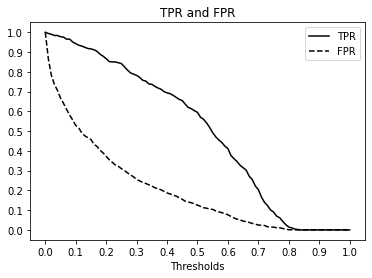

In [175]:
plt.figure(figsize=(6, 4))

plt.plot(df_scores.threshold, df_scores.tpr, color='black', linestyle='solid', label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, color='black', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('TPR and FPR')

# plt.savefig('04_fpr_tpr_plot.svg')

plt.show()